<a href="https://colab.research.google.com/github/BengiNouri/Project2/blob/main/Clean_Preprocessing%2BFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

car_data = pd.read_csv('/content/drive/MyDrive/car_data_raw.csv', delimiter=',', encoding='ISO-8859-1')

In [4]:
# Remove punctuations from Price
car_data['Price'] = car_data['Price'].str.replace('.', '').astype(int)

In [5]:
# Make year into a number and remove the month
def extract_year(x):
    if pd.notna(x):
        four_digits = x[-4:]
        two_digits = x[-2:]

        if four_digits.isdigit() and len(four_digits) == 4:
            return four_digits
        elif two_digits.isdigit() and len(two_digits) == 2:
            return f"20{two_digits}" if int(two_digits) <= 30 else f"19{two_digits}"
    return np.nan

car_data['Year'] = car_data['Production Year'].apply(extract_year).astype(float)

car_data['Year'] = pd.to_numeric(car_data['Year'], errors='coerce')
car_data = car_data.drop(columns=['Production Year'])


In [6]:
# Filter out cars produced in 2024 and before 1990
cardata = car_data[(car_data['Year'] != 2024) & (car_data['Year'] >= 1990)]

# Remove the columns 'Unnamed: 57' and 'Unnamed: 58'
cardata = cardata.drop(columns=['Unnamed: 57', 'Unnamed: 58'])

In [7]:
# Filter out ethanol cars
cardata = cardata[cardata['Car Name'] != "Renault Twingo 1,2 16V Authentique ECO2"]

In [8]:
# Step 1: Separate 'Car Name' into 'Brand' and 'Model'
cardata[['Brand', 'Model']] = cardata['Car Name'].str.split(n=1, expand=True)

def clean_model(row):
    brand = row['Brand']
    model = row['Model']
    if brand == "Tesla":
        match = re.search(r"(Model 3|Model Y|Model S|Model X)", model)
        if match:
            return match.group(1)
        else:
            return model.split(' ')[0]
    return model.split(' ')[0]

cardata['Model'] = cardata.apply(clean_model, axis=1)
cardata.drop(columns=['Car Name'], inplace=True)

In [9]:
# Split up 'Motor Specs' and extract the data from it
cardata['Motor_Specs_Cleaned'] = cardata['Motor Specs'].str.replace(r'^\d+\.\d+\s+', '', regex=True)

cardata['Fuel_Type'] = cardata['Motor_Specs_Cleaned'].str.extract(r'^(\D+)', expand=False)
cardata['Horsepower'] = cardata['Motor_Specs_Cleaned'].str.extract(r'(\d+)\s?(?=HK)', expand=False)
cardata['Horsepower'] = pd.to_numeric(cardata['Horsepower'], errors='coerce')

cardata = cardata.drop(columns=['Motor_Specs_Cleaned'])

In [10]:
# Cleaning the Gear column
category_counts = cardata['Gear'].value_counts()
print(category_counts)

# it can be seen that the 'gear' column contains some values that are not relevant.

# Transform 'Gear' based on its content
cardata['Gear'] = np.where(cardata['Gear'].str.contains('Automatgear', na=False), 'Automatgear',
                           np.where(cardata['Gear'].str.contains('Manuelt gear', na=False), 'Manuelt gear',
                                    np.nan))

category_counts2 = cardata['Gear'].value_counts()
print(category_counts2)


Gear
Automatgear                4258
Manuelt gear\n\n6-trins    2765
Manuelt gear\n\n5-trins    2312
Automatgear\n\n7-trins     2294
Automatgear\n\n6-trins     1457
Manuelt gear               1414
Automatgear\n\n8-trins     1376
Automatgear\n\n9-trins      358
Automatgear\n\n5-trins      129
Automatgear\n\n3-trins       38
Automatgear\n\n4-trins       35
Manuelt gear\n\n9-trins      24
Manuelt gear\n\n7-trins      12
Manuelt gear\n\n8-trins      12
Manuelt gear\n\n3-trins       5
Manuelt gear\n\n4-trins       4
Name: count, dtype: int64
Gear
Automatgear     9945
Manuelt gear    6548
Name: count, dtype: int64


In [11]:
# Clean 'Km/L' by removing any line breaks and asterisks
cardata['Km/L'] = cardata['Km/L'].str.replace(r'\n\*', '', regex=True)

# Convert 'Km/L' to numeric, ignoring errors so non-numeric data becomes NaN
cardata['Km/L'] = pd.to_numeric(cardata['Km/L'], errors='coerce')

# Setting 'Km/L' to NaN where 'Fuel_Type' is 'EL'
cardata.loc[cardata['Fuel_Type'] == 'EL', 'Km/L'] = np.nan


In [12]:
# List of columns to be removed
# This is for feature engineering
columns_to_remove = [
    'ABS', 'Alarm', 'Aircondition', 'Alloy Rim', 'Bluetooth', 'Centrallock',
    'El-Ruder', 'El-spejle', 'Kurvelys', 'Kørecomputer', 'Multifunktionsrat',
    'Servo', 'Stop&Go', 'Vejbane Advarselssystem', 'Sport Seats', 'Reverse Camera',
    'Blindvinkelassistent', 'Digital Instrumentering', 'Electronic Trunck Opener',
    'Color', 'closest_color', 'StandardizedColor'
]

# Drop these columns
cardata = cardata.drop(columns=columns_to_remove, errors='ignore')

In [13]:
# Counting the zeros in the 'KM Driven' column
zero_count = (cardata['KM Driven'] == 0).sum()

print(zero_count)

# Filter out rows where 'KM Driven' is not zero
cardata = cardata[cardata['KM Driven'] != 0]


282


In [14]:
# Disable scientific notation for integers globally
pd.set_option('display.float_format', lambda x: '%.0f' % x)

summary_stats = cardata.describe()
print(summary_stats)


       KM Driven  Km/L   Price  Year  Horsepower
count      16211 13839   16211 16211       15980
mean       93812    22  228761  2018         168
std        80293    10  168394     5          86
min            1     5    3210  1990          15
25%        28000    17  119900  2016         110
50%        76000    21  199000  2019         150
75%       139000    24  299000  2021         204
max       700000   242 2499900  2023         996


In [15]:
# See the datatypes for all variables
data_types = cardata.dtypes
print(data_types)

KM Driven                    int64
Variant                     object
Km/L                       float64
Range (Electric)            object
Gear                        object
Motor Specs                 object
Price                        int64
GPS                         object
Trailer Hitch               object
4WD                         object
Parkingsensor               object
Cruise Control              object
Antispin                    object
ESP                         object
El-SÃ¦der                   object
Leather Interior            object
Glass Roof                  object
Headup Display              object
Isofix                      object
KlimaanlÃ¦g                 object
KÃ¸recomputer               object
Regnsensor                  object
Soltag                      object
Sports Package              object
Seatwarmer                  object
Xenon Lights                object
Non-Smoker                  object
One-Owner                   object
Service OK          

In [16]:
# Count the number of occurrences of each brand
brand_counts = cardata['Brand'].value_counts()
print(brand_counts)

Brand
VW            2297
Mercedes      1514
Peugeot       1132
Skoda         1105
Audi          1075
Ford          1028
BMW            883
Renault        786
CitroÃ«n       642
Opel           568
Hyundai        554
Kia            544
Nissan         502
Volvo          460
Toyota         397
Seat           395
Suzuki         318
Fiat           298
Mazda          282
Tesla          264
Dacia          133
Cupra          126
Mini           125
Polestar       105
Mitsubishi      98
Porsche         95
MG              81
Honda           75
Chevrolet       60
Jaguar          60
Alfa            44
Land            35
Jeep            29
Subaru          21
Lexus           16
Dodge           12
Maserati        11
Ferrari         10
Saab             8
Lotus            7
Chrysler         7
Rover            5
Cadillac         3
Pontiac          1
Name: count, dtype: int64


In [17]:
cardata = cardata.groupby('Brand').filter(lambda x: len(x) >= 40)
cardata = cardata[cardata['Brand'] != 'Porsche']

In [18]:
# Count the number of occurrences of each brand
brand_counts = cardata['Brand'].value_counts()
print(brand_counts)

Brand
VW            2297
Mercedes      1514
Peugeot       1132
Skoda         1105
Audi          1075
Ford          1028
BMW            883
Renault        786
CitroÃ«n       642
Opel           568
Hyundai        554
Kia            544
Nissan         502
Volvo          460
Toyota         397
Seat           395
Suzuki         318
Fiat           298
Mazda          282
Tesla          264
Dacia          133
Cupra          126
Mini           125
Polestar       105
Mitsubishi      98
MG              81
Honda           75
Jaguar          60
Chevrolet       60
Alfa            44
Name: count, dtype: int64


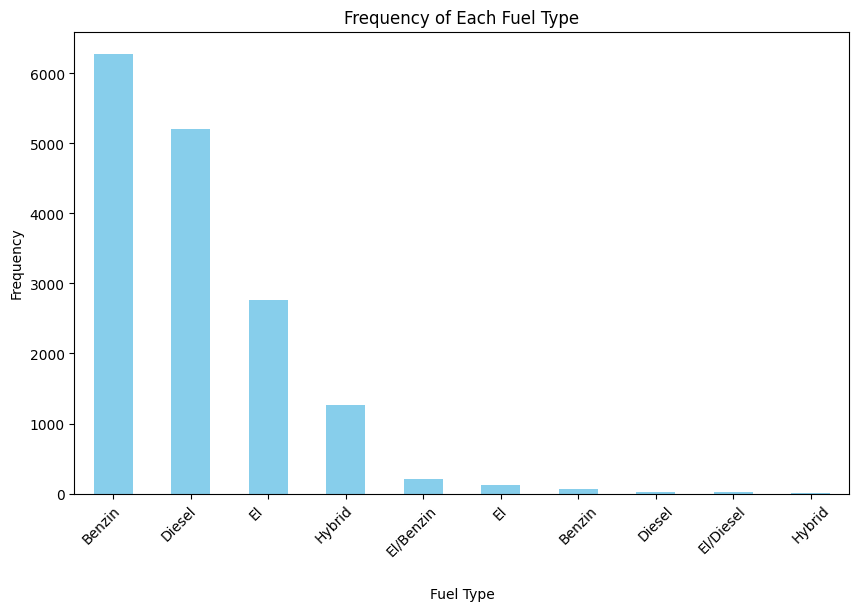

In [19]:
# Plot fuel_type variable
fuel_type_counts = cardata['Fuel_Type'].value_counts()

plt.figure(figsize=(10, 6))
fuel_type_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Fix variable 'Fuel Type' where there are different input with the same meaning
cardata['Fuel_Type'] = cardata['Fuel_Type'].str.replace("\\n", "", regex=True).str.strip()

def standardize_fuel_type(fuel_type):
    if 'Hybrid' in fuel_type or 'El/Diesel' in fuel_type or 'El/Benzin' in fuel_type:
        return 'Hybrid'
    elif 'El' in fuel_type:
        return 'El'
    elif 'Diesel' in fuel_type:
        return 'Diesel'
    elif 'Benzin' in fuel_type:
        return 'Benzin'
    else:
        return fuel_type
cardata['Fuel_Type'] = cardata['Fuel_Type'].apply(standardize_fuel_type)


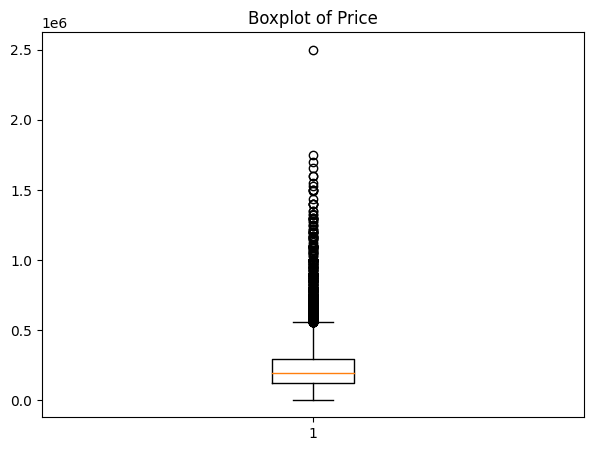

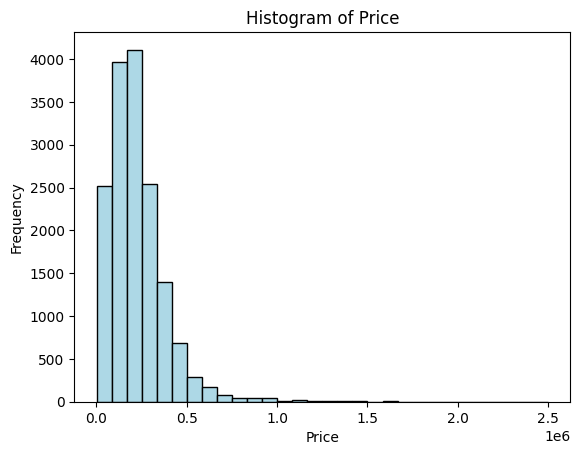

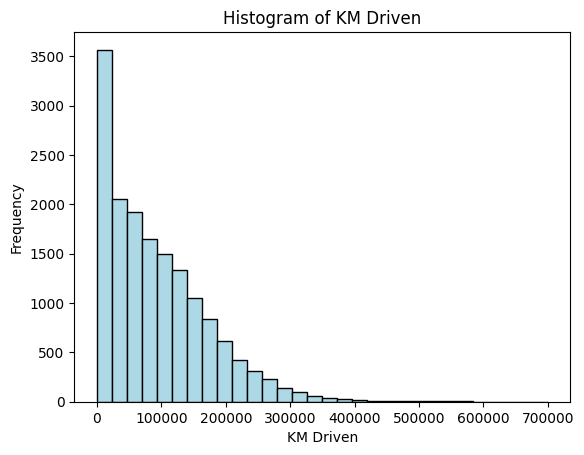

In [ ]:
# Create boxplots to visualize outliers in numerical variables
fig, axs = plt.subplots(figsize=(7,5))
axs.boxplot(cardata["Price"])
axs.set_title("Boxplot of Price")
plt.show()

# Create a histogram of the 'Price' column
plt.hist(cardata['Price'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Create a histogram of the 'KM Driven' column
plt.hist(cardata['KM Driven'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of KM Driven')
plt.xlabel('KM Driven')
plt.ylabel('Frequency')
plt.show()

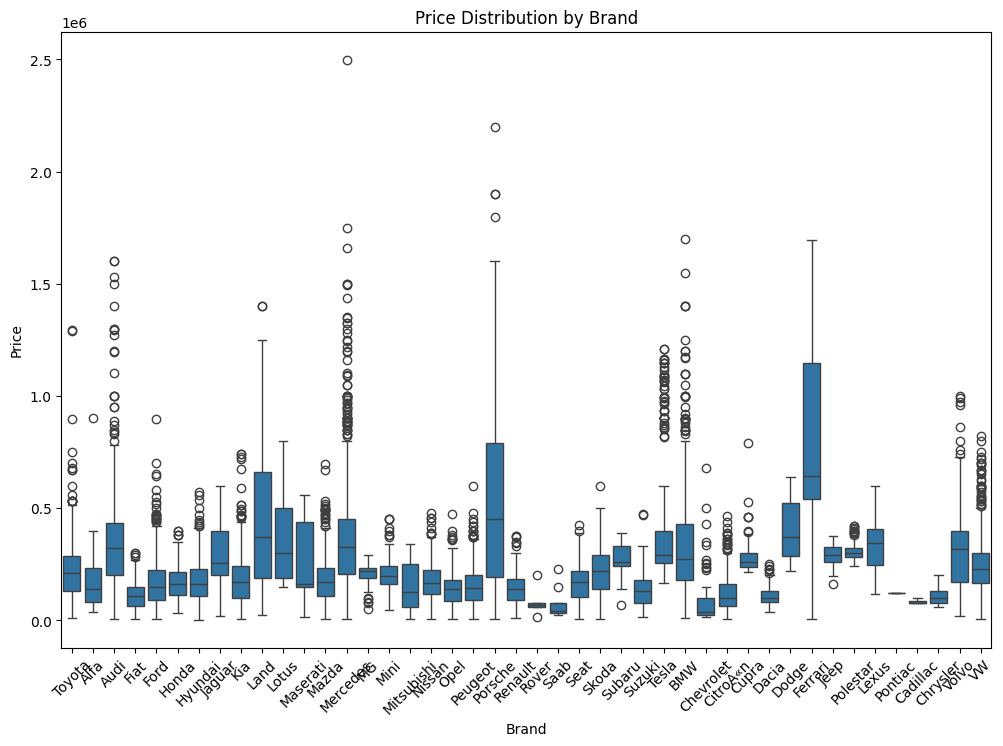

In [ ]:
# Boxplot of price distribution by brand
plt.figure(figsize=(12, 8))
sns.boxplot(x='Brand', y='Price', data=cardata)
plt.title('Price Distribution by Brand')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


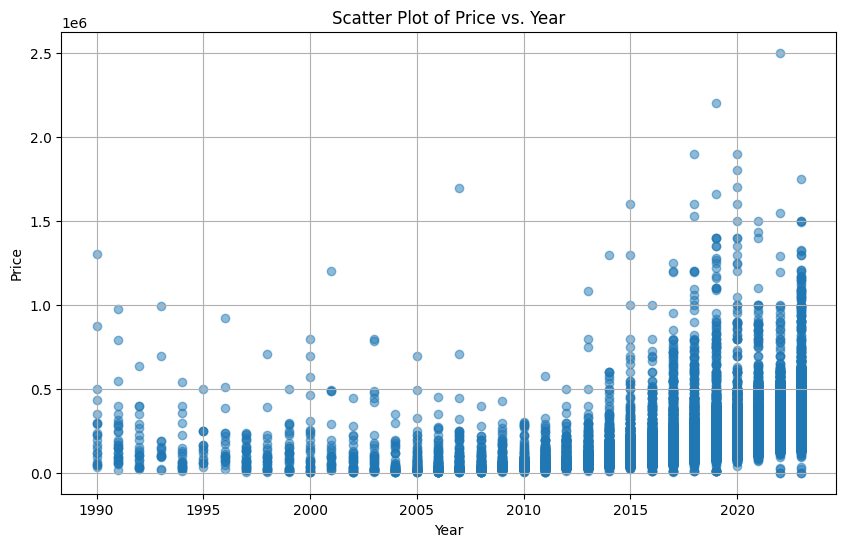

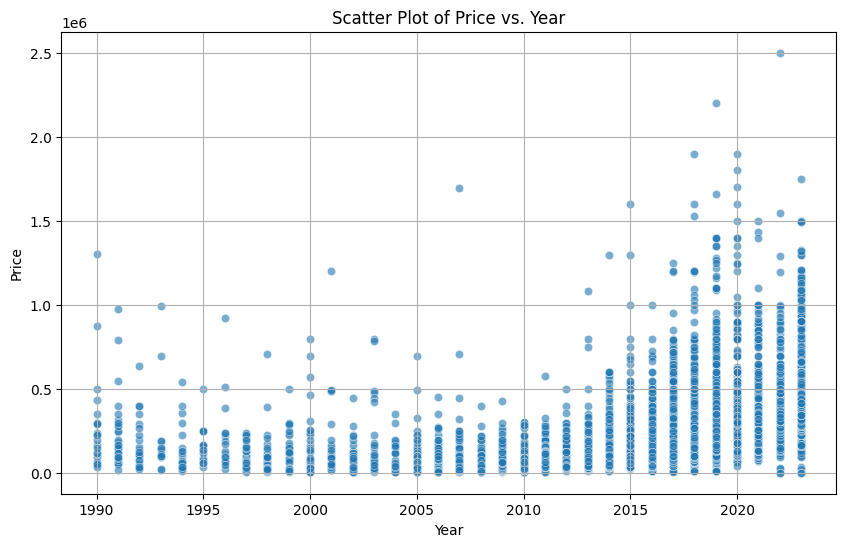

In [ ]:
# Scatterplot of price on production year
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Price', data=cardata, alpha=0.6)
plt.title('Scatter Plot of Price vs. Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()



In [ ]:
# Looking at the correlation between price and other variables
cor_data = cardata[['Price', 'KM Driven', 'Horsepower', 'Year']]
correlation_matrix = cor_data.corr()
print(correlation_matrix)

In [ ]:
# Plot the distribution of KM Driven
plt.figure(figsize=(10, 6))
plt.hist(cardata['KM Driven'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Plot of Horsepower
plt.figure(figsize=(10, 6))
sns.histplot(cardata['Horsepower'], bins=40, kde=True, color='red')
plt.title('Distribution of Horsepower')
plt.xlabel('Horsepower')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Show distribution of brands
brand_counts = cardata['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Get top 20 and bottom 20 brands
top_10_brands = brand_counts.head(20)
bottom_10_brands = brand_counts.tail(20)

# Plot top
plt.figure(figsize=(8, 4))
barplot = sns.barplot(data=top_10_brands, x='Brand', y='Count')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Car Brands by Frequency')
plt.ylabel('Counts')
plt.xlabel('Brand')
plt.show()

# Plot bottom
plt.figure(figsize=(8, 4))
barplot = sns.barplot(data=bottom_10_brands, x='Brand', y='Count')
plt.xticks(rotation=45, ha='right')  # Rotate brand names for better visibility
plt.title('Bottom 10 Car Brands by Frequency')
plt.ylabel('Counts')
plt.xlabel('Brand')
plt.show()



In [ ]:
cardata['Variant'] = cardata['Variant'].replace('-', np.nan)

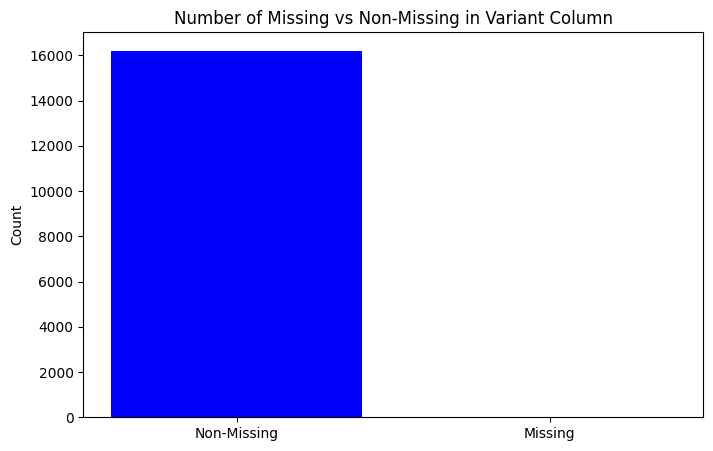

In [ ]:
# Make a plotbar
missing_count = cardata['Variant'].isna().sum()
non_missing_count = cardata['Variant'].notna().sum()
counts = [non_missing_count, missing_count]
labels = ['Non-Missing', 'Missing']


plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['blue', 'red'])
plt.title('Number of Missing vs Non-Missing in Variant Column')
plt.ylabel('Count')
plt.show()


In [ ]:
# Config for plotting
num_plots = 4
num_rows = 2
num_columns = 2

plt.figure(figsize=(10, 8))

# Loop for making the plots in the selected columns, done several times to plot all the necessary columns
for i, column in enumerate(cardata.columns[9:13]):
    plt.subplot(num_rows, num_columns, i + 1)
    sns.countplot(x=cardata[column])
    plt.title(f'Frequency of {column}')
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

In [21]:
# Defining and removing outliers

def remove_outliers(group):
    q1 = group['Price'].quantile(0.25)
    q3 = group['Price'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    return group[(group['Price'] < upper) & (group['Price'] > lower)]

cardata = cardata.groupby('Brand').apply(remove_outliers).reset_index(drop=True)

In [22]:
# Dividing the cars into segments based on the salesprice
def price_segment(Price):
    if Price > 270000:
        return 'Premium'
    elif Price > 150000:
        return 'Mid-Range'
    else:
        return 'Economy'

cardata['Segment'] = cardata['Price'].apply(price_segment)

In [23]:
# Checking the amount of the variable 'Variant' in the dataset
variant_counts = cardata['Variant'].value_counts()
print(variant_counts)

table = pd.DataFrame(variant_counts)
table.reset_index(inplace=True)
table.columns = ['Variant', 'Count']
print(table)

Variant
-               3463
Style            706
AMG line         487
Comfortline      369
Active           358
                ... 
Joy                1
Cool Edition       1
MY23               1
Nakama             1
Sense              1
Name: count, Length: 338, dtype: int64
          Variant  Count
0               -   3463
1           Style    706
2        AMG line    487
3     Comfortline    369
4          Active    358
..            ...    ...
333           Joy      1
334  Cool Edition      1
335          MY23      1
336        Nakama      1
337         Sense      1

[338 rows x 2 columns]


In [24]:
# Removing the variable 'Variant' from the dataset
cardata = cardata.drop('Variant', axis=1)

In [25]:
cardata.drop(columns=['Motor Specs'], inplace=True)
columns_to_replace = ['GPS', 'Trailer Hitch', '4WD', 'Parkingsensor', 'Cruise Control', 'Antispin', 'ESP', 'El-SÃ¦der', 'Leather Interior', 'Glass Roof', 'Headup Display', 'Isofix', 'KlimaanlÃ¦g', 'Regnsensor', 'Soltag', 'Sports Package', 'Seatwarmer', 'Xenon Lights', 'Non-Smoker', 'One-Owner', 'Service OK', 'Nysynet', 'Demo Car', 'Partly Leather Interior', 'CVR/Engros', 'Full Leather', 'Adaptive Cruise Control', 'KÃ¸recomputer']
cardata[columns_to_replace] = cardata[columns_to_replace].replace({'Yes': 1, 'No': 0})

In [26]:
# Check how the variable 'Km/L' is distributed
km_per_l_counts = cardata['Km/L'].value_counts(dropna=False)


print(km_per_l_counts)

Km/L
NaN    2203
23      418
20      364
20      316
24      312
       ... 
41        1
26        1
64        1
52        1
70        1
Name: count, Length: 426, dtype: int64


In [27]:
# Check the column 'Range (Electric)'
if 'Range (Electric)' in cardata.columns:
    range_counts = cardata['Range (Electric)'].value_counts(dropna=False)
    print(range_counts)
else:
    print("Column 'Range (Electric)' does not exist in DataFrame.")

Range (Electric)
NaN       12944
424 Km       88
537 Km       70
411 Km       54
429 Km       54
          ...  
319 Km        1
330 Km        1
273 Km        1
291 Km        1
579 Km        1
Name: count, Length: 249, dtype: int64


In [28]:
# Impute missing 'Range (Electric)' and 'Km/L' based on the brand and fuel_type mean
cardata['Range (Electric)'] = pd.to_numeric(cardata['Range (Electric)'].str.replace(' Km', ''), errors='coerce')

km_per_l_mean = cardata.groupby(['Brand', 'Fuel_Type'])['Km/L'].transform('mean')
range_electric_mean = cardata.groupby(['Brand', 'Fuel_Type'])['Range (Electric)'].transform('mean')

cardata['Km/L'] = cardata['Km/L'].fillna(km_per_l_mean)
cardata['Range (Electric)'] = cardata['Range (Electric)'].fillna(range_electric_mean)

cardata['Km/L'] = cardata['Km/L'].fillna(cardata['Km/L'].mean())
cardata['Range (Electric)'] = cardata['Range (Electric)'].fillna(cardata['Range (Electric)'].mean())


In [29]:
# Convert 'KM Driven', 'Km/L', 'Range (Electric)', 'Price', and 'Horsepower' to be numeric
numeric_columns = ['KM Driven', 'Km/L', 'Range (Electric)', 'Price', 'Horsepower']
for col in numeric_columns:
    cardata[col] = pd.to_numeric(cardata[col], errors='coerce')

# Convert factor-like columns
factor_columns = [col for col in cardata.columns if cardata[col].dtype == 'object']
for col in factor_columns:
    cardata[col] = cardata[col].astype('category')

# Check if the changes has been done correct
print(cardata.dtypes)

KM Driven                     int64
Km/L                        float64
Range (Electric)            float64
Gear                       category
Price                         int64
GPS                           int64
Trailer Hitch                 int64
4WD                           int64
Parkingsensor                 int64
Cruise Control                int64
Antispin                      int64
ESP                           int64
El-SÃ¦der                     int64
Leather Interior              int64
Glass Roof                    int64
Headup Display                int64
Isofix                        int64
KlimaanlÃ¦g                   int64
KÃ¸recomputer                 int64
Regnsensor                    int64
Soltag                        int64
Sports Package                int64
Seatwarmer                    int64
Xenon Lights                  int64
Non-Smoker                    int64
One-Owner                     int64
Service OK                    int64
Nysynet                     

In [30]:
# Round 'Km/L' and 'Range (Electric)' to no decimal
cardata['Km/L'] = cardata['Km/L'].round(0)
cardata['Range (Electric)'] = cardata['Range (Electric)'].round(0)


In [31]:
# Check NaN values  in all columns
na_count = cardata.isna().sum()
print(na_count)

KM Driven                    0
Km/L                         0
Range (Electric)             0
Gear                         0
Price                        0
GPS                          0
Trailer Hitch                0
4WD                          0
Parkingsensor                0
Cruise Control               0
Antispin                     0
ESP                          0
El-SÃ¦der                    0
Leather Interior             0
Glass Roof                   0
Headup Display               0
Isofix                       0
KlimaanlÃ¦g                  0
KÃ¸recomputer                0
Regnsensor                   0
Soltag                       0
Sports Package               0
Seatwarmer                   0
Xenon Lights                 0
Non-Smoker                   0
One-Owner                    0
Service OK                   0
Nysynet                      0
Demo Car                     0
Partly Leather Interior      0
CVR/Engros                   0
Full Leather                 0
Adaptive

In [32]:
# Impute missing Horsepower on 'Brand' and 'Fuel_Type' mean
brand_mean_horsepower = cardata.groupby(['Brand', 'Fuel_Type'])['Horsepower'].transform('mean')
cardata['Horsepower'] = cardata['Horsepower'].fillna(brand_mean_horsepower)

# Incase theres some NA means based on 'Brand' & 'Fuel_Type' combination, use global mean
overall_mean_horsepower = cardata['Horsepower'].mean()
cardata['Horsepower'] = cardata['Horsepower'].fillna(overall_mean_horsepower)

In [41]:
# Split the dataset into 2 seperate CSV's based on 'Fuel Type' El = 'EV' & BDH = 'ICEV'
# First, split the dataset based on 'Fuel_Type'
car_data_dbh = cardata[cardata['Fuel_Type'].isin(['Benzin', 'Diesel', 'Hybrid'])]
car_data_el = cardata[cardata['Fuel_Type'] == 'El']

car_data_dbh = pd.get_dummies(car_data_dbh, columns=['Fuel_Type'])

car_data_dbh = car_data_dbh.drop(columns=['Range (Electric)'])

car_data_el = car_data_el.drop(columns=['Fuel_Type'])

car_data_dbh.to_csv('new_car_data_dbh123.csv', index=False)
car_data_el.to_csv('new_car_data_el123.csv', index=False)
